In [16]:
%reload_ext autoreload
%autoreload 2

from lib.data_loading import load_measurements, CombinedDataLoader

####

from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt


data_dir = "data"
model_dir = Path("./models")
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Data resides in        : {data_dir}")
print(f"Model will be saved to : {model_dir}")

Data resides in        : data
Model will be saved to : models


In [17]:
import jax, jax.numpy as jnp
from flax import linen as nn
from typing import Tuple, Dict, Any

PRNGKey = jax.random.PRNGKey


class ConditionalRBM(nn.Module):
    num_visible: int               # number of visible units (N)
    num_hidden: int                # number of hidden units (H)
    film_width: int = 64
    k: int = 1                     # CD-k steps
    T: float = 1.0                 # temperature

    def setup(self):
        self.W  = self.param("W", nn.initializers.normal(0.01), (self.num_visible, self.num_hidden))
        self.b  = self.param("b", nn.initializers.zeros, (self.num_visible,))
        self.c0 = self.param("c", nn.initializers.zeros, (self.num_hidden,))

    @nn.compact
    def _condition_encoder(self, cond_flat: jnp.ndarray) -> Tuple[jnp.ndarray, jnp.ndarray]:
        x = nn.Dense(self.film_width)(cond_flat)
        x = nn.tanh(x)
        x = nn.Dense(2 * self.num_hidden)(x)
        gamma, beta = jnp.split(x, 2, axis=-1)
        return gamma, beta

    def _free_energy(self, v: jnp.ndarray, c_mod: jnp.ndarray) -> jnp.ndarray:
        lin_term = -(v @ self.b)
        hidden_term = jnp.sum(jax.nn.softplus(v @ self.W + c_mod), axis=-1)
        return lin_term - hidden_term

    def _gibbs_step(self, state: Tuple[jnp.ndarray, PRNGKey], c_mod: jnp.ndarray, temp: float) -> Tuple[jnp.ndarray, PRNGKey]:
        v, key = state
        key, key_h, key_v = jax.random.split(key, 3)
        h = jax.random.bernoulli(key_h, jax.nn.sigmoid((v @ self.W + c_mod) / temp)).astype(jnp.float32)
        v = jax.random.bernoulli(key_v, jax.nn.sigmoid((h @ self.W.T + self.b) / temp)).astype(jnp.float32)
        return v, key

    def __call__(self, batch: jnp.ndarray, key: PRNGKey) -> Tuple[jnp.ndarray, PRNGKey]:
        # batch contains visible data and conditioning information (B, N, 1 + C)

        data = batch[..., 0].astype(jnp.float32)   # (B, N)
        cond = batch[..., 1:]                      # (B, N, C)
        B, N = data.shape

        # perform film modulation first
        gamma, beta = self._condition_encoder(cond.reshape(B, -1))              # (B, H), (B, H)
        c_mod = (1 + gamma) * self.c0 + beta

        # gibbs sampling from a fresh chain using the film-modulated biases of the hidden units
        key, key_init = jax.random.split(key)
        gibbs_chain = jax.random.bernoulli(key_init, 0.5, shape=(B, N)).astype(jnp.float32)  # (B, N) ....this could vary tbh
        gibbs_step_fn = lambda _, s: self._gibbs_step(s, c_mod, temp=self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (gibbs_chain, key_init))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain) # cut off gradients after Gibbs sampling

        # calculate the CD
        loss = jnp.mean(self._free_energy(data, c_mod)) - jnp.mean(self._free_energy(gibbs_chain, c_mod))
        return loss, key

    @nn.nowrap
    def generate(self, cond: jnp.ndarray, T_schedule: jnp.ndarray, key: PRNGKey) -> Tuple[jnp.ndarray, PRNGKey]:
        # conditioning tensor basically looks like a training batch, but without the data channel (B, N, C)

        B, N, C = cond.shape

        gamma, beta = self._condition_encoder(cond.reshape(B, -1))
        c_mod = (1 + gamma) * self.c0 + beta

        key, key_init = jax.random.split(key)
        gibbs_chain = jax.random.bernoulli(key_init, 0.5, shape=(B, N)).astype(jnp.float32)  # (k, B, N)

        gibbs_step_fn = lambda i, s: self._gibbs_step(s, c_mod, temp=T_schedule[i])
        gibbs_chain, _ = jax.lax.fori_loop(0, len(T_schedule), gibbs_step_fn, (gibbs_chain, key_init))
        return gibbs_chain, key

In [21]:
@jax.jit
def train_step_cond(state: TrainState, batch: jnp.ndarray, key: jax.random.PRNGKey) -> Tuple[TrainState, jnp.ndarray]:
    loss_fn = lambda params: state.apply_fn({'params': params}, batch, key)[0]

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


def train_cond_rbm(
        state: TrainState,
        loader: CombinedDataLoader,
        num_epochs: int,
        key: PRNGKey) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, Any] = {}
    for epoch in range(num_epochs):
        tot_loss, batches = 0.0, 0

        for batch in loader:
            key, key_batch = jax.random.split(key)
            state, loss = train_step_cond(state, batch, key_batch)
            tot_loss += float(loss)
            batches  += 1

        avg_loss = tot_loss / batches
        lr = float(lr_schedule(state.opt_state[0].count))

        metrics[epoch] = dict(loss=avg_loss, lr=lr)
        
        print(f"Epoch {epoch+1}/{num_epochs} │ "
            f"Loss: {avg_loss:+.4f} │ "
            f"Learning Rate: {lr:.5f}")

    return state, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2

    curve_fn = lambda step: low + (high - low) / (1 + jnp.exp(falloff * (jnp.minimum(step, steps) - center_step)))
    return curve_fn

In [22]:
file_path = Path("data/w_aug_combined.txt")
data = load_measurements(file_path)

Parsing measurements: 100%|██████████| 20000/20000 [00:00<00:00, 24467.47it/s]


In [31]:
batch_size   = 64
num_qubits   = 8
hidden_units = 16
film_width = 32
k_steps      = 600
num_epochs   = 100
init_lr      = 1e-2
final_lr     = init_lr * 0.1


key_seed = PRNGKey(42)
key, key_params, key_dummy = jax.random.split(key_seed, 3)

model = ConditionalRBM(num_visible=num_qubits, num_hidden=hidden_units, film_width=32, k=k_steps)

dummy_batch = jnp.zeros((batch_size, num_qubits, 3), dtype=jnp.float32)
variables = model.init({'params': key_params}, dummy_batch, key_dummy)

loader = CombinedDataLoader(data, batch_size=batch_size)

schedule_steps = num_epochs * len(loader)
lr_schedule = get_sigmoid_curve(high=init_lr, low=final_lr, steps=schedule_steps, falloff=0.0005)
optimizer = optax.adam(lr_schedule)

state = TrainState.create(apply_fn=model.apply, params=variables['params'], tx=optimizer)

state, metrics = train_cond_rbm(state, loader, num_epochs=num_epochs, key=key)

Epoch 1/100 │ Loss: +0.0133 │ Learning Rate: 0.01000
Epoch 2/100 │ Loss: +0.0217 │ Learning Rate: 0.01000
Epoch 3/100 │ Loss: +0.0265 │ Learning Rate: 0.00999
Epoch 4/100 │ Loss: +0.0206 │ Learning Rate: 0.00999
Epoch 5/100 │ Loss: +0.0284 │ Learning Rate: 0.00999
Epoch 6/100 │ Loss: +0.0214 │ Learning Rate: 0.00999
Epoch 7/100 │ Loss: +0.0300 │ Learning Rate: 0.00999
Epoch 8/100 │ Loss: +0.0320 │ Learning Rate: 0.00999
Epoch 9/100 │ Loss: +0.0239 │ Learning Rate: 0.00999
Epoch 10/100 │ Loss: +0.0274 │ Learning Rate: 0.00998
Epoch 11/100 │ Loss: +0.0266 │ Learning Rate: 0.00998
Epoch 12/100 │ Loss: +0.0263 │ Learning Rate: 0.00998
Epoch 13/100 │ Loss: +0.0277 │ Learning Rate: 0.00997
Epoch 14/100 │ Loss: +0.0310 │ Learning Rate: 0.00997
Epoch 15/100 │ Loss: +0.0244 │ Learning Rate: 0.00996
Epoch 16/100 │ Loss: +0.0284 │ Learning Rate: 0.00996
Epoch 17/100 │ Loss: +0.0330 │ Learning Rate: 0.00995
Epoch 18/100 │ Loss: +0.0254 │ Learning Rate: 0.00994
Epoch 19/100 │ Loss: +0.0307 │ Learni

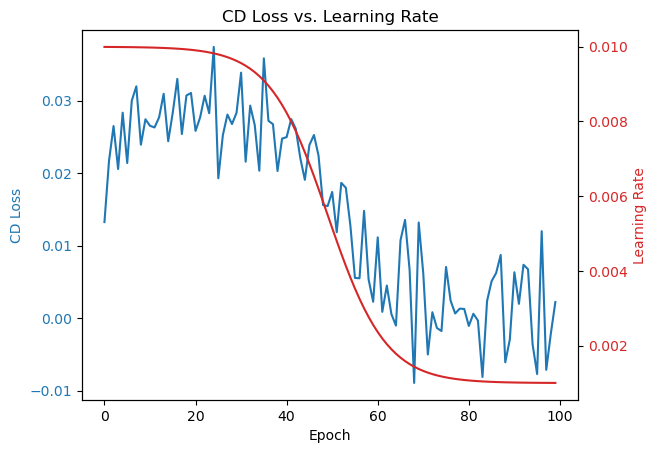

In [32]:
epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")

ax1.plot(epochs, loss_vals, label="CD Loss", color="tab:blue")
ax1.set_ylabel("CD Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax2.set_ylabel("Learning Rate", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("CD Loss vs. Learning Rate")
plt.show()

In [33]:
T_high = 2.0
T_low = 0.01
sampling_steps = 5_000
sigmoid_schedule_fn = get_sigmoid_curve(high=T_high*2, low=T_low, steps=sampling_steps, falloff=0.0013, center_step=0)
sigmoid_schedule = jnp.array([sigmoid_schedule_fn(i) for i in range(sampling_steps)], dtype=jnp.float32)

num_samples = 10_000
dir_bits = jnp.ones((num_samples, model.num_visible, 2), dtype=jnp.int32)

key_sample = PRNGKey(1234)
samples, _ = model.apply({'params': state.params}, dir_bits, sigmoid_schedule, key_sample, method=ConditionalRBM.generate)

# the output samples still have all three channels, we need only want to know the frequencies from the outcome channel
sampled_freq = samples.mean(axis=0)
sampled_freq

Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

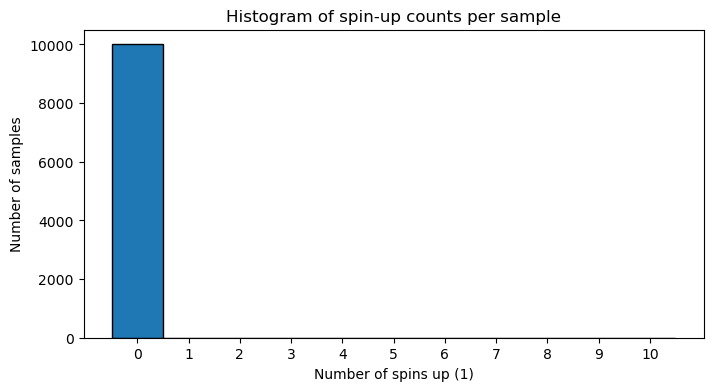

In [34]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(12), align='left', edgecolor='black')
plt.xticks(range(11))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()